In [0]:
!pip install keras==2.2.4

In [0]:
!git clone https://github.com/aspamers/autoencoder.git

fatal: destination path 'autoencoder' already exists and is not an empty directory.


In [0]:
%cd autoencoder
%pwd

/content/autoencoder


'/content/autoencoder'

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Deconv2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, Flatten, Dense

from autoencoder import AutoEncoder

batch_size = 128
num_classes = 10
epochs = 100

# input image dimensions
img_rows, img_cols = 28, 28

Using TensorFlow backend.


## Load data

In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
#for pca plot
y_test_2 = y_test

## Create model

In [0]:
def create_encoder_model(input_shape):
    model_input = Input(shape=input_shape)

    encoder = Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=input_shape)(model_input)
    encoder = BatchNormalization()(encoder)
    encoder = Activation(activation='relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder)

    encoder = Conv2D(64, kernel_size=(3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation(activation='relu')(encoder)
    encoder = MaxPooling2D(pool_size=(2, 2))(encoder)

    encoder = Flatten()(encoder)
    encoder = Dense(128)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation(activation='relu')(encoder)

    return Model(model_input, encoder)


def create_decoder_model(embedding_shape):
    embedding_a = Input(shape=embedding_shape)

    decoder = Dense(1 * 28 * 28)(embedding_a)
    decoder = BatchNormalization()(decoder)
    decoder = Activation(activation='relu')(decoder)
    decoder = Reshape(input_shape)(decoder)

    return Model(embedding_a, decoder)

## Train the auto encoder

In [0]:
num_classes = 10
epochs = 100

encoder_model = create_encoder_model(input_shape)
decoder_model = create_decoder_model(encoder_model.output_shape)
autoencoder_network = AutoEncoder(encoder_model, decoder_model)
autoencoder_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(), metrics=['accuracy'])

autoencoder_checkpoint_path = "./autoencoder_checkpoint"

autoencoder_callbacks = [
    EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    ModelCheckpoint(autoencoder_checkpoint_path, monitor='val_acc', save_best_only=True, verbose=0)
]

autoencoder_network.fit(x_train, x_train,
                        validation_data=(x_test, x_test),
                        batch_size=128,
                        epochs=epochs,
                        callbacks=autoencoder_callbacks)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 121us/step - loss: 1.7816 - acc: 0.6687 - val_loss: 1.0493 - val_acc: 0.7279
Epoch 2/100
60000/60000 [==============================] - 5s 82us/step - loss: 0.9289 - acc: 0.7378 - val_loss: 0.7499 - val_acc: 0.7563
Epoch 3/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.6640 - acc: 0.7666 - val_loss: 0.5481 - val_acc: 0.7777
Epoch 4/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.5236 - acc: 0.7797 - val_loss: 0.4542 - val_acc: 0.7858
Epoch 5/100
60000/60000 [==============================] - 5s 87us/step - loss: 0.4300 - acc: 0.7864 - val_loss: 0.3921 - val_acc: 0.7911
Epoch 6/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.3752 - acc: 0.7898 - val_loss: 0.4236 - val_acc: 0.7863
Epoch 7/100

## Add softmax output layer and train with y label

In [0]:
autoencoder_network.load_weights(autoencoder_checkpoint_path)
embedding = encoder_model.outputs[-1]

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Add softmax layer to the pre-trained embedding network
embedding = Dense(num_classes)(embedding)
embedding = BatchNormalization()(embedding)
embedding = Activation(activation='sigmoid')(embedding)

model = Model(encoder_model.inputs[0], embedding)
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

model_checkpoint_path = "./model_checkpoint"

model_callbacks = [
    EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    ModelCheckpoint(model_checkpoint_path, monitor='val_acc', save_best_only=True, verbose=0)
]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=epochs,
          callbacks=model_callbacks,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.4555 - acc: 0.8916 - val_loss: 0.3824 - val_acc: 0.9701
Epoch 2/100
60000/60000 [==============================] - 5s 82us/step - loss: 0.2760 - acc: 0.9895 - val_loss: 0.2264 - val_acc: 0.9948
Epoch 3/100
60000/60000 [==============================] - 5s 82us/step - loss: 0.1860 - acc: 0.9956 - val_loss: 0.1524 - val_acc: 0.9972
Epoch 4/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.1315 - acc: 0.9971 - val_loss: 0.1100 - val_acc: 0.9977
Epoch 5/100
60000/60000 [==============================] - 5s 83us/step - loss: 0.0963 - acc: 0.9979 - val_loss: 0.0823 - val_acc: 0.9980
Epoch 6/100
60000/60000 [==============================] - 5s 86us/step - loss: 0.0723 - acc: 0.9984 - val_loss: 0.0635 - val_acc: 0.9980
Epoch 7/100
60000/60000 [==============================] - 5s 82us/step - loss: 0.0556 - acc: 0.9986 - val_loss: 0.0482 - 

In [0]:
model.load_weights(model_checkpoint_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0481859649181366
Test accuracy: 0.9982499956130981


## Plot 2-D diagram by PCA

In [0]:
import numpy as np

x_1 = (np.expand_dims(x_test[0],0))
print(encoder_model.predict(x_1))
print(np.argmax(model.predict(x_1)))
print(y_test[0])

[[0.         1.241616   0.         0.9810908  0.         0.
  0.         1.5303364  0.3002258  0.         1.4217842  0.5932955
  0.48014733 1.3520018  0.5343754  1.6899569  1.6826675  0.
  1.2523108  0.         0.8069246  0.         1.9087977  0.23506749
  1.3210145  0.         0.9622834  0.45989847 0.81568897 0.
  1.4317884  0.         0.9420541  0.79949987 0.         1.0173792
  0.         0.         0.         0.         0.         0.
  1.4649045  0.         0.         0.         0.99123085 0.
  0.         0.         0.5414846  0.         0.         1.5249497
  0.         0.         0.         0.         0.5902318  0.
  0.         1.7344719  0.         0.01510453 0.02077508 0.
  0.         1.5720011  0.61004174 1.8687017  0.6747159  0.
  0.         0.9759983  0.         2.0486608  0.88272095 0.
  0.         1.003164   0.         1.3270786  0.9449717  0.
  1.412219   0.6430987  0.         0.6118269  0.         0.
  0.         0.         1.1105781  0.         0.9240248  0.35629487
  0

In [0]:
x_code = encoder_model.predict(x_test)

In [0]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#0000FF', '#000000', '#FF0000', '#66FF66','#FFFF66', '#9999FF', '#660033', '#FF6666', '#C0C0C0']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.title('Dataset PCA (n_components = 2)')

    plt.show()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10).fit(x_code)

X_pca = pca.transform(x_code)

In [0]:
print(len(x_code))
print(len(X_pca))
print(len(y_test))
print(y_test_2)

10000
10000
10000
[7 2 1 ... 4 5 6]


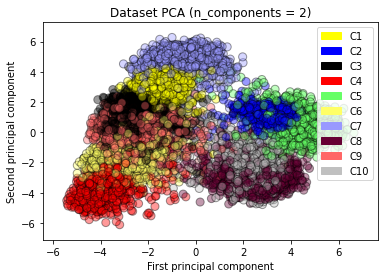

In [0]:
plot_labelled_scatter(X_pca, y_test_2, ['C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9','C10'])

## Sequence-to-sequence autoencoder

In [0]:
#from keras.models import Model

#inputs = Input(shape=(timesteps, input_dim))
#encoded = LSTM(latent_dim)(inputs)

#decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(input_dim, return_sequences=True)(decoded)

#sequence_autoencoder = Model(inputs, decoded)
#encoder = Model(inputs, encoded)